In [1]:
# Keras
# Input tokens        : char-based with embeddings
# Classification type : binary
# Prediction output   : multi-nodes

In [78]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pickle
import time
import string

from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.layers import Convolution1D, MaxPooling1D, Flatten
from keras.layers.convolutional import Conv1D
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer, one_hot, text_to_word_sequence
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.models import load_model
from keras.layers.wrappers import TimeDistributed

from keras.utils.visualize_util import plot
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import sys
print(sys.version)

3.5.2 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [2]:
# Functions

def get_word2index(texts_ls_):
    word2index_ = {}

    c = 1
    for text_str in texts_ls_:
        text_tokens_ls = text_str.lower().split()
        for token in text_tokens_ls:
            if(token not in word2index_):
                word2index_[token] = c
                c = c + 1
                
    return word2index_

def train_df_preprocess(top_words_, texts_ls_, max_pad_length_):
    # texts_ls_: list of texts strings
    
    tok = Tokenizer(top_words_)
    tok.fit_on_texts(texts_ls_)

    words = []
    for iter in range(top_words):
        words += [key for key,value in tok.word_index.items() if value==iter+1]

    #Class for vectorizing texts, or/and turning texts into sequences 
    #(=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i).
    texts_vec_ls = tok.texts_to_sequences(texts_ls_)#turns text to sequence, stating which word comes in what place
    texts_vec_mtx = sequence.pad_sequences(texts_vec_ls, maxlen=max_pad_length_)#pad sequence, essentially padding it with 0's at the end
    
    return texts_vec_mtx

def text_2_vec(text_str, word2index_):
    # text_str: text string
    
    text_tokens_ls = text_str.lower().split()
    
    text_vec = []
    for token in text_tokens_ls:
        if token in word2index_:
            text_vec.append(word2index_[token])
        else:
            text_vec.append(0)
            
    return text_vec

def train_df_preprocess_2(texts_ls_, word2index_, max_pad_length_):
    # texts_ls_: list of texts strings
    
    texts_vec_ls = []
    for text_ in texts_ls_:
        #print(text_)
        #print(type(text_))
        text_vec = text_2_vec(text_, word2index_)
        texts_vec_ls.append(text_vec)
    
    texts_vec_ary = sequence.pad_sequences(texts_vec_ls, maxlen=max_pad_length_)
    
    return texts_vec_ary

def texts_to_sequences_custom(texts_ls, word_index_):
    texts_seq = []
    
    for text in texts_ls:
        text_split = text.lower().split()
        seq = []
        for token in text_split:
            if(token in word_index_):
                seq.append(word_index_[token])
            else:
                seq.append(0)
                
        texts_seq.append(seq)
#         for k,v in word_index_.items():
#             if(v == 395):
#                 print(k,v)
    return texts_seq


def text_chars_to_sequences_custom(text_chars_ls, char_index_):
    texts_seq = []
    
    for text in text_chars_ls:
        text_split = text.lower().split()
        seq = []
        for token in text_split:
            if(token in char_index_):
                seq.append(char_index_[token])
            else:
                seq.append(0)
                
        texts_seq.append(seq)
#         for k,v in word_index_.items():
#             if(v == 395):
#                 print(k,v)
    return texts_seq

def get_model_file_aux(model_file_aux_name):
    with open(model_file_aux_name, 'rb') as pickle_file:
        model_file_aux = pickle.load(pickle_file)
    return model_file_aux

In [3]:
# Read train set (screwdrivers)
pkl_file = '/Users/altay.amanbay/Desktop/new node booster/experiments/3a.1 - Nets train/train_data.pkl'
train_df = pd.read_pickle(pkl_file)

# Create target feature
train_df['target'] = train_df['type'].apply(lambda x: 'False' if x == 'False Positive' else 'Positive')

# Drop index column
train_df.drop(labels=['type'], axis=1, inplace=True)

# Encode target feature
#le = LabelEncoder()
#le.fit(train_df['target'])
#train_df['target_le'] = le.transform(train_df['target'])


# cat = 'Tools & Home Improvement > Power & Hand Tools > Hand Tools > Screwdrivers'
# positives, negatives = get_positives_negatives(train_df, cat)
# X_train = input_text = pd.concat([positives, negatives])
# y_train = [1] * len(positives) + [0] * len(negatives)

print('train data shape:',train_df.shape)
train_df.head(2)

train data shape: (6822, 4)


,description_mod1,category_id_mod1,category_full_path_mod1,target
0,RION TECH 5 point 6 point 3 Piece Tool Kit Pen...,927,Tools & Home Improvement > Power & Hand Tools ...,Positive
1,Stalwart 25-piece 4.8V Cordless Screwdriver Set,927,Tools & Home Improvement > Power & Hand Tools ...,False


In [4]:
# Read sampled descriptionary

path = '/Users/altay.amanbay/Desktop/new node booster/experiments/train data from descriptionary nodes by sampling/3 - Picking samples from each node/sampled descriptionary/'
file_name = 'sampled_descriptionary_sample_size_5000.csv'
samples_df = pd.read_csv(path + file_name)

# Rename columns
samples_df.rename(columns={'description': 'description_mod1', 
                           'category_id': 'category_id_mod1',
                           'category_path': 'category_full_path_mod1'}, inplace=True)

# Drop 'screwdrivers' from descriptionary
#samples_df = samples_df.loc[samples_df.category_id_mod1 != 927,:]

# Drop index column
samples_df.drop(labels=['index'], axis=1, inplace=True)

# Add target column and make all false as all items are not screwdrivers
samples_df['target'] = 'False'
samples_df.loc[samples_df.category_id_mod1 == 927,['target']] = 'Positive'

print('samples data shape:',samples_df.shape)
samples_df.head()

samples data shape: (956776, 4)


,description_mod1,category_id_mod1,category_full_path_mod1,target
0,!iT Jeans Maternity Skinny Jeans Dark Wash M,100,Apparel & Accessories > Apparel > Maternity,False
1,1822 Denim 'Butter' Maternity Skinny Jeans Rin...,100,Apparel & Accessories > Apparel > Maternity,False
2,25 J Brand Maternity Skinny Jean nirvana blue,100,Apparel & Accessories > Apparel > Maternity,False
3,26 J Brand Maternity Skinny Jean nirvana blue,100,Apparel & Accessories > Apparel > Maternity,False
4,26 James Jeans Maternity Skinny External Mater...,100,Apparel & Accessories > Apparel > Maternity,False


In [5]:
def modif_1(phrase):
    phrase_mod =  " ".join((char if char.isalnum() else "") for char in phrase.lower())
    phrase_mod = ' '.join(phrase_mod.split())
    return phrase_mod

def modif_2(phrase, remove_chars=['ï','½','®','™','©','ž','볶','불','양','¢','õ','î','€']):
    phrase_mod = " ".join((char if char in string.printable else " ") for char in phrase.lower())
    phrase_mod =  " ".join((char if char.isalnum() else "") for char in phrase_mod)
    phrase_mod = ' '.join(phrase_mod.split())
    return phrase_mod

modif_1('!iT Jeans Maternity Skinny')

'i t j e a n s m a t e r n i t y s k i n n y'

In [6]:
# Concat original train set and sampled descriptionary
train_df = pd.concat([train_df, samples_df], axis=0)
train_df.reset_index(drop=True, inplace=True)
print('train data shape:',train_df.shape)

# description into chars
train_df['description_mod1'] = train_df['description_mod1'].apply(lambda x: modif_1(x))

# deduplicate
train_df.drop_duplicates(subset=['description_mod1'], inplace = True)
print('train data shape (deduplicate):',train_df.shape)
    

# Encode target feature
le = LabelEncoder()
#le.fit(train_df['target'])
#train_df['target_le'] = le.transform(train_df['target'])
le.fit(train_df['category_full_path_mod1'])
train_df['target_le'] = le.transform(train_df['category_full_path_mod1'])



train_df.head(2)

train data shape: (963598, 4)
train data shape (deduplicate): (945464, 4)


,description_mod1,category_id_mod1,category_full_path_mod1,target,target_le
0,r i o n t e c h 5 p o i n t 6 p o i n t 3 p i ...,927,Tools & Home Improvement > Power & Hand Tools ...,Positive,395
1,s t a l w a r t 2 5 p i e c e 4 8 v c o r d l ...,927,Tools & Home Improvement > Power & Hand Tools ...,False,395


In [7]:
# Split into train and test
#X = train_df.loc[:,['description_mod1']]
X_ls = np.array(list(train_df['description_mod1']))
#y_ary = np.array(list(train_df['target_le']))
y_ary_cat = np_utils.to_categorical(train_df['target_le'])
# X_ls = train_df[['description_mod1']]
# y_ary = train_df[['target_le']]

print(type(X_ls))
#print(type(y_ary))
print(type(y_ary_cat))

#X_train_ls, X_test_ls, y_train_ary, y_test_ary = train_test_split(X_ls, y_ary, test_size = 0.3)
X_train_ls, X_test_ls, y_train_ary, y_test_ary = train_test_split(X_ls, y_ary_cat, test_size = 0.3)

# print(X_train_df.shape)
# print(X_test_df.shape)
print(len(X_train_ls))
print(len(X_test_ls))
print(y_train_ary.shape)
#print(y_test_ary.shape)
print(y_test_ary.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
661824
283640
(661824, 404)
(283640, 404)


In [8]:
# Convert train set into sequences for nets

top_words = 200000
max_description_length = 100

# tok = Tokenizer(nb_words = top_words)
# tok.fit_on_texts(X_train_ls)
# word_index = tok.word_index
# print('word_index size:',len(word_index))


ls = '0123456789abcdefghijklmnopqrstuvwxyz'
word_index = {}
for i, c in enumerate(ls):
    word_index[c] = i+1 #ord(c)
print('word_index size:',len(word_index))

# train_texts_vec_ls = tok.texts_to_sequences(X_train_ls)
# train_texts_vec_ls = texts_to_sequences_custom(X_train_ls, word_index)
train_texts_vec_ls = text_chars_to_sequences_custom(X_train_ls, word_index)
train_texts_vec_mtx = sequence.pad_sequences(train_texts_vec_ls, maxlen = max_description_length)

print('train_texts_vec_mtx shape:',train_texts_vec_mtx.shape)
#list(tok.word_index)[0:5]

word_index size: 36
train_texts_vec_mtx shape: (661824, 100)


In [9]:
# Convert test set into sequences for nets

#test_texts_vec_ls = tok.texts_to_sequences(X_test_ls)
#test_texts_vec_ls = texts_to_sequences_custom(X_test_ls, word_index)
test_texts_vec_ls = text_chars_to_sequences_custom(X_test_ls, word_index)
test_texts_vec_mtx = sequence.pad_sequences(test_texts_vec_ls, maxlen = max_description_length)

In [50]:
# Create RANDOM embedding vectors for each word in word index (lower cell code preferable)
# fix random seed for reproducibility
np.random.seed(7)

embedding_vecor_length = 1 #32
#uniq_token_count = len(tok.word_index)
uniq_token_count = len(word_index)
print('word index size:', uniq_token_count)

embedding_matrix = np.zeros((len(word_index) + 1, embedding_vecor_length))
for word, i in word_index.items():
    embedding_vector = np.random.uniform(.1, size=(1, embedding_vecor_length))
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('embedding matrix shape:',embedding_matrix.shape)
print(embedding_matrix[0])
print(embedding_matrix[1])

word index size: 36
embedding matrix shape: (37, 1)
[ 0.]
[ 0.28436418]


In [52]:
# Best model result holder
best_model_aux = {}
best_model_aux['Max length'] = max_description_length
best_model_aux['Best Score'] = 0
#best_model_aux['Category ID'] = 927
#best_model_aux['Category name'] = 'Tools & Home Improvement > Power & Hand Tools > Hand Tools > Screwdrivers'
#best_model_aux['Tokenizer'] = tok
best_model_aux['Word index'] = word_index

best_model = None

In [43]:
# Optional
# Load previous model (if needs to be compared in the following training)
#best_model = load_model('category_927_nets_1000_model.h5')
#best_model_aux = get_model_file_aux('category_927_nets_1000_model_aux.pkl')

In [82]:
best_model_aux['Best Score']

0

In [54]:
# prediction nodes count
classes_ls = train_df['category_full_path_mod1'].unique()
print('Classes count:', len(classes_ls))

Classes count: 404


In [103]:
# TRAIN MODEL 2

start = time.time()

# define/initialize model
top_words = len(word_index) + 1
batch_size_ = 32   # 64
hidden_nodes = 100
nb_filter_1 = 128
nb_filter_2 = 128
filter_length_1 = 5
filter_length_2 = 5
subsample_length_ = 2  #stride

model = Sequential()
embedding_layer = Embedding(input_dim=top_words, 
                            output_dim=embedding_vecor_length, 
                            weights=[embedding_matrix], 
                            input_length = max_description_length, # e.g. time_steps
                            #batch_input_shape=(batch_size_, max_description_length), # use batch_input_shape when stateful=True
                            trainable=True)
model.add(embedding_layer)

conv1D_1 = Convolution1D(nb_filter = nb_filter_1
                        ,filter_length = 10
                        ,border_mode='valid'  # same, valid
                        ,activation='sigmoid'
                        ,subsample_length=2
                        )
model.add(conv1D_1)
conv1D_2 = Convolution1D(nb_filter = nb_filter_1
                        ,filter_length = 6
                        ,border_mode='valid'  # same, valid
                        ,activation='sigmoid'
                        ,subsample_length=6
                        )
model.add(conv1D_2)
#model.add(MaxPooling1D(pool_length = 2, stride = 2)) #model.output_shape[1]
#model.add(Dropout(0.2))

# conv1D_3 = Convolution1D(nb_filter = nb_filter_2
#                         ,filter_length = 1
#                         ,border_mode='valid'  # same, valid
#                         ,activation='sigmoid'
#                         ,subsample_length=1
#                         )
# model.add(conv1D_3)
# model.add(MaxPooling1D(pool_length = 4, stride = 2)) #model.output_shape[1]


model.add(Flatten())
model.add(Dense(100, activation='sigmoid')) # sigmoid, relu
#model.add(Dropout(0.2))
model.add(Dense(len(classes_ls), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # try binary_crossentropy,categorical_crossentropy
print(model.summary())

# start training multiple times with epoch=1
for ep in range(40):
    print('Epoch iter #' + str(ep+1))
    
    #model.fit(X_train_ary, y_train_ary, validation_data=(X_train_ary, y_train_ary), nb_epoch=5, batch_size=64)
    model.fit(train_texts_vec_mtx 
              ,y_train_ary 
              ,validation_data=(test_texts_vec_mtx, y_test_ary)
              ,nb_epoch=1
              ,batch_size=batch_size_
             )
    
    scores = model.evaluate(test_texts_vec_mtx, y_test_ary, verbose=0)
    if(best_model_aux['Best Score'] < scores[1]):
        best_model_aux['Best Score'] = scores[1]
        best_model = model
        print('Captured improved model')
        #print("Accuracy on test set: %.2f%%" % (scores[1]*100))
    print()
 

print("Training took %g s" % (time.time() - start))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_59 (Embedding)         (None, 100, 1)        37          embedding_input_44[0][0]         
____________________________________________________________________________________________________
convolution1d_67 (Convolution1D) (None, 46, 128)       1408        embedding_59[0][0]               
____________________________________________________________________________________________________
convolution1d_68 (Convolution1D) (None, 7, 128)        98432       convolution1d_67[0][0]           
____________________________________________________________________________________________________
flatten_28 (Flatten)             (None, 896)           0           convolution1d_68[0][0]           
___________________________________________________________________________________________

KeyboardInterrupt: 

In [38]:
# TRAIN MODEL 1
start = time.time()

# define/initialize model
top_words = len(word_index) + 1
batch_size_ = 64   # 64
hidden_nodes = 100

model = Sequential()
embedding_layer = Embedding(input_dim=top_words, 
                            output_dim=embedding_vecor_length, 
                            weights=[embedding_matrix], 
                            input_length = max_description_length, # e.g. time_steps
                            #batch_input_shape=(batch_size_, max_description_length), # use batch_input_shape when stateful=True
                            trainable=True)
#model.add(embedding_layer)
LSTM_1 = LSTM(hidden_nodes
               ,input_shape=(max_description_length, 1)
               #,batch_input_shape=(batch_size_,max_description_length,embedding_vecor_length)
               #,inner_activation='sigmoid'
               ,return_sequences=True
               ,stateful=False)
#model.add(LSTM_1)
model.add(Dense(100, input_shape = (max_description_length,), activation='sigmoid'))
model.add(Dense(100))
#model.add(LSTM(hidden_nodes, return_sequences=False))
model.add(Dense(len(classes_ls), activation='softmax'))  # try activation='sigmoid' or 'softmax'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # try binary_crossentropy,categorical_crossentropy
print(model.summary())

# start training multiple times with epoch=1
for ep in range(10):
    print('Epoch iter #' + str(ep+1))
    
    #model.fit(X_train_ary, y_train_ary, validation_data=(X_train_ary, y_train_ary), nb_epoch=5, batch_size=64)
    model.fit(train_texts_vec_mtx 
              ,y_train_ary 
              ,validation_data=(test_texts_vec_mtx, y_test_ary)
              ,nb_epoch=1
              ,batch_size=batch_size_
             )
    
    scores = model.evaluate(test_texts_vec_mtx, y_test_ary, verbose=0)
    if(best_model_aux['Best Score'] < scores[1]):
        best_model_aux['Best Score'] = scores[1]
        best_model = model
        print('Captured improved model')
        #print("Accuracy on test set: %.2f%%" % (scores[1]*100))
    print()
 

print("Training took %g s" % (time.time() - start))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_16 (Dense)                 (None, 100)           10100       dense_input_2[0][0]              
____________________________________________________________________________________________________
dense_17 (Dense)                 (None, 100)           10100       dense_16[0][0]                   
____________________________________________________________________________________________________
dense_18 (Dense)                 (None, 404)           40804       dense_17[0][0]                   
Total params: 61,004
Trainable params: 61,004
Non-trainable params: 0
____________________________________________________________________________________________________
None
Epoch iter #1
Train on 661824 samples, validate on 283640 samples
Epoch 1/1
661824/661824 [==========================

KeyboardInterrupt: 

In [67]:
best_model_aux['Best Score']
#model.summary()

0.0074954167254265968

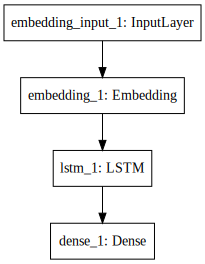

In [17]:
# Plot Nets design
#plot(model, to_file='/Users/altay.amanbay/Desktop/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [21]:
# Save model and aux file

best_model.save('category_927_char_nets__traindata5000_vecRand32_model.h5')

best_model_aux_name = 'category_' + str(best_model_aux['Category ID']) + '_char_nets__traindata5000_vecRand32_aux.pkl'
with open(best_model_aux_name, 'wb') as pickle_file:
    pickle.dump(best_model_aux, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

### Evaluation (optional)

In [32]:
# Final evaluation of the model
start = time.time()

scores = model.evaluate(train_texts_vec_mtx, y_train_ary, verbose=0)
print("Accuracy on train set: %.2f%%" % (scores[1]*100))
scores = model.evaluate(test_texts_vec_mtx, y_test_ary, verbose=0)
print("Accuracy on test set: %.2f%%" % (scores[1]*100))

print("\nEvaluation took %g s" % (time.time() - start))

Accuracy on train set: 0.74%
Accuracy on test set: 0.75%

Evaluation took 898.337 s


In [33]:
# Get predictions
start = time.time()

predictions = model.predict_classes(test_texts_vec_mtx)
#predictions_rnd = np.round_(predictions, decimals=0, out=None)
predictions_probs = model.predict(test_texts_vec_mtx)

print('%-20s' % "predictions[0]",':', predictions[0])
#print('%-20s' % "predictions_rnd[0]:",':',predictions_rnd[0])
print('%-20s' % "predictions_probs[0]",':', predictions_probs[0])
print("\nPrediction took %g s" % (time.time() - start))

283616/283640 [============================>.] - ETA: 0spredictions[0]       : 395
predictions_probs[0] : [  1.57149884e-06   5.65032766e-04   1.04814411e-04   5.06013026e-03
   5.31121530e-03   4.95075528e-03   1.98241978e-05   7.38064784e-07
   1.62571894e-06   1.47916691e-03   5.60404314e-03   2.19421601e-03
   4.82816860e-04   1.95416564e-04   2.55046121e-04   5.14175044e-03
   5.52940881e-03   5.39144361e-03   5.11699403e-03   5.67135401e-03
   5.35661727e-03   4.90648160e-03   5.15679037e-03   5.24536800e-03
   4.55971481e-03   4.68741730e-03   5.20593440e-03   4.98983636e-03
   3.76462145e-03   8.63722448e-07   5.17276628e-03   5.28980745e-03
   5.56021743e-03   5.44886524e-03   5.58351073e-03   5.23483707e-03
   5.26121212e-03   5.10279415e-03   5.32342913e-03   4.61317226e-03
   3.19392816e-03   5.70044620e-03   5.20968484e-03   5.22209983e-03
   5.17882500e-03   5.29204309e-03   5.36386063e-03   5.31700253e-03
   4.97335242e-03   5.22622885e-03   5.18467510e-03   5.03673637e-

In [34]:
#pd.crosstab(pd.Series(y_test_ary.ravel()), pd.Series(predictions_rnd.ravel()), rownames=['True'], colnames=['Predicted'], margins=True)
pd.crosstab(pd.Series(np_utils.categorical_probas_to_classes(y_test_ary)), pd.Series(predictions), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,395,All
True,,
1,160,160
2,32,32
3,1513,1513
4,1508,1508
5,1520,1520
6,6,6
9,350,350
10,1465,1465
11,586,586


In [18]:
pd.crosstab(pd.Series(np_utils.categorical_probas_to_classes(y_test_ary)), pd.Series(predictions.ravel()), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,285926,81,286007
1,163,1410,1573
All,286089,1491,287580


### Testing

In [19]:
#model.get_config()
def prediction_to_str(clf_prediction, category_id):
    if(clf_prediction > 0.5):
        return str(category_id)
    else:
        return 'not ' + str(category_id)

def predict(description_str, word_index_, clf_, max_length_, category_id_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str.lower()], word_index_)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    clf_prediction = clf_.predict(seq_pad)
    
    #print(seq_)
    #print(seq_pad)
    
    # Prediction to string
    clf_prediction_str = prediction_to_str(clf_prediction[0][0], category_id_)
    
    return clf_prediction_str
    #return clf_prediction[0][0]

def predict_2(description_str, word_index_, clf_, max_length_, category_id_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str.lower()], word_index_)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    #clf_prediction = clf_.predict(seq_pad)
    clf_prediction = clf_.predict_classes(seq_pad)
    
    #print(seq_)
    #print(seq_pad)
    
    # Prediction to string
    #clf_prediction_str = prediction_to_str(clf_prediction[0][0], category_id_)
    clf_prediction = le.inverse_transform(clf_prediction)
    
    if(clf_prediction == ['Positive']):
        return str(category_id_)
    else:
        return 'not ' + str(category_id_)
    
    
def predict_proba(description_str, tok_, clf_, max_length_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str], tok_.word_index)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    clf_prediction_proba = clf_.predict_proba(seq_pad, verbose=0)
    
    return clf_prediction_proba[0][0]


# id_ = 'table Setr'
# p = predict(id_, best_model_aux['Tokenizer'], best_model, best_model_aux['Max length'], best_model_aux['Category ID'])
# pp = predict_proba(id_, best_model_aux['Tokenizer'], best_model, best_model_aux['Max length'])
# print(p)
# print(pp)

In [20]:
# TEST

## load old model
model_file = "category_927_nets__traindata5000_vectrain5000_model.h5"
aux_file = "category_927_nets__traindata5000_vectrain5000_aux.pkl"
old_best_model_ = load_model(model_file)
old_best_model_aux_ = get_model_file_aux(aux_file)
old_tok_ = old_best_model_aux_['Tokenizer']
old_word_index_ = old_best_model_aux_['Tokenizer'].word_index

## use fresh model
best_model_ = best_model
best_model_aux_ = best_model_aux
tok_ = tok
word_index_ = word_index

item_d = 'NieR: Automata™ DEMO 120161128 (Playable Demo)'

# screwdrivers check
scrw_items = [
"tekton 2655 flare nut wrench set metric 6piece"
,"tekton 2780 10slot screwdriver holder and organizer"
,"titan 17237 insulated electrical screwdriver set  7 piece"
,"tool sorter screwdriver organizer red"
,"torin sdh15rt magnetic screwdriver holder"  #wrong predict
,"wera 05020013001 joker combination wrenchset 11 pieces"
,"wera kk vde 60i62i68i18 insulated pouch set with interchangeable blades 18piece" # tricky
,"wiha 28103 magnetic 14 bit holder stubby 57mm pliers screwdriver" # tricky, wrong predict
]

for n, i in enumerate(scrw_items):
    item_d = i
    
    print(str(n) + ' ' + '='*100)
    
    print('Old model prediction:')
    print('item:',item_d)
    print('Seq max len:', old_best_model_aux_['Max length'])
    print(predict(modif_1(item_d), old_tok_, old_best_model_, old_best_model_aux_['Max length'], '927'))
    print(predict_proba(item_d, word_index, old_best_model_, old_best_model_aux_['Max length']))


    print('\nFresh model prediction:')
    print('item:',item_d)
    print('Seq max len:', best_model_aux_['Max length'])
    print(predict_2(modif_1(item_d), word_index, best_model_, best_model_aux_['Max length'], '927'))
    #print(predict_proba(item_d, tok_, best_model_, best_model_aux_['Max length']))

    print()

    #tt = train_df.loc[0:10,['description_mod1']]
    #tt['pred'] = tt['description_mod1'].apply(lambda x: predict(x, best_model_aux_['Tokenizer'], best_model, best_model_aux_['Max length'], best_model_aux_['Category ID']))
    #tt['prob'] = tt['description_mod1'].apply(lambda x: predict_proba(x, best_model_aux_['Tokenizer'], best_model, best_model_aux_['Max length']))

0 ====================================================================================================
Old model prediction:
item: tekton 2655 flare nut wrench set metric 6piece
Seq max len: 30
not 927
4.17323e-08

Fresh model prediction:
item: tekton 2655 flare nut wrench set metric 6piece
Seq max len: 100
1/1 [==============================] - 0s
not 927

1 ====================================================================================================
Old model prediction:
item: tekton 2780 10slot screwdriver holder and organizer
Seq max len: 30
not 927
0.121584

Fresh model prediction:
item: tekton 2780 10slot screwdriver holder and organizer
Seq max len: 100
1/1 [==============================] - 0s
not 927

2 ====================================================================================================
Old model prediction:
item: titan 17237 insulated electrical screwdriver set  7 piece
Seq max len: 30
not 927
0.998989

Fresh model prediction:
item: titan 17237 insulate